In [ ]:
!git clone --depth=1 https://github.com/open-quantum-safe/liboqs-python

Cloning into 'liboqs-python'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 33 (delta 3), reused 17 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 25.64 KiB | 4.27 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
!apt-get update
!apt-get install -y cmake ninja-build gcc make python3-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,526 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,911 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd

In [ ]:
%cd liboqs-python
!pip install .

/content/liboqs-python
Processing /content/liboqs-python
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for liboqs-python: filename=liboqs_python-0.12.0-py3-none-any.whl size=12437 sha256=2417e7d315c2b05e79d367af0717f97ea0b3aeb82f16df9837a0bb427a6e3092
  Stored in directory: /root/.cache/pip/wheels/88/6a/34/7b907e7c67601095491eb47ea991c49facb1ce071d5b40d09c
Successfully built liboqs-python


In [ ]:
import oqs

liboqs not found, installing it in /root/_oqs


INFO:oqs.oqs:liboqs not found, installing it in /root/_oqs


Installing in 5 seconds...


INFO:oqs.oqs:Installing in 5 seconds...


Installing in 4 seconds...


INFO:oqs.oqs:Installing in 4 seconds...


Installing in 3 seconds...


INFO:oqs.oqs:Installing in 3 seconds...


Installing in 2 seconds...


INFO:oqs.oqs:Installing in 2 seconds...


Installing in 1 seconds...


INFO:oqs.oqs:Installing in 1 seconds...


Done installing liboqs


INFO:oqs.oqs:Done installing liboqs


In [ ]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.9 MB/s eta 0:00:00


## Kyber+

Key Enhancements:
- Multithreading: Threads are used to parallelize the key generation, encryption, and decryption processes for different algorithms, improving performance.
- Hybrid Encryption: Combines Kyber for key exchange with AES for encrypting the plaintext message.
- Batch Processing: Although this example processes algorithms sequentially within threads, you could extend it to handle multiple messages in batches.
- Input/Output text


ToDo:
- graphs - Done
- figure out a metric for loss - Shanon Entropy, Chi Square, Hamming
- figure why relation isn't consistent

## Kyber’s Role (Key Encapsulation Mechanism - KEM)
Kyber is a post-quantum key encapsulation mechanism (KEM), which means it does not encrypt the plaintext directly.

Instead, it is used for secure key exchange, meaning:
- A public and private key pair is generated using kem.generate_keypair(). The shared secret is encapsulated using kem.encap_secret(public_key), producing:
  - A ciphertext (used for key exchange)
  - A shared secret (used as an encryption key)
  - The receiver decapsulates the shared secret using kem.decap_secret(ciphertext), retrieving the same shared secret.
- This ensures quantum-safe key exchange between two parties.

---

## AES’s Role (Hybrid Encryption of the Actual Message)
After obtaining the shared secret from Kyber, it is used as the encryption key for AES. AES is a symmetric encryption algorithm, meaning the same key is used for both encryption and decryption.

The steps for AES encryption:
 - Take the first 16 bytes of Kyber’s shared secret as the AES key.
 - Generate a random initialization vector (IV).
 - Use AES in CBC mode to encrypt the actual plaintext message.
 - The IV is prepended to the ciphertext, so it can be used for decryption.

The steps for AES decryption:
- Extract the first 16 bytes of the ciphertext as the IV.
- Decrypt the message using the same shared secret as the AES key.

In [ ]:
# Function to read a text file and extract sentences
def read_text_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()  # Read the entire content

    # Split text into sentences using a full stop (.)
    sentences = text.split(".")

    # Remove empty lines, extra spaces, and line breaks
    sentences = [sentence.strip().replace("\n", " ") for sentence in sentences if sentence.strip()]

    return sentences

# Path to your text file
file_path1 = "/content/plaintext-small.txt"
file_path2 = "/content/plaintext-large.txt"

# Read and process the file
sentence_list_small = read_text_file(file_path1)[:120]
sentence_list_large = read_text_file(file_path2)[:600]

# Print the cleaned list of sentences
# print(sentence_list)
print(len(sentence_list_small))
print(len(sentence_list_large))

120
600


In [ ]:
import time
import oqs
import threading
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import os
from collections import Counter
import math

def shannon_entropy(data):
    if not data:
        return 0
    frequency = Counter(data)  # Count occurrences of each byte
    total_length = len(data)
    entropy = -sum((count / total_length) * math.log2(count / total_length) for count in frequency.values())
    return entropy

# Chi-Square Test Calculation
def chi_square_test(data):
    expected_freq = len(data) / 256  # Expected uniform distribution
    observed_freq = Counter(data)  # Count occurrences of each byte

    chi_square_stat = sum(((observed_freq.get(byte, 0) - expected_freq) ** 2) / expected_freq for byte in range(256))
    return chi_square_stat

# Hamming Distance Calculation
def hamming_distance(data1, data2):
    """Compute Hamming Distance between two byte sequences."""
    return sum(bin(b1 ^ b2).count('1') for b1, b2 in zip(data1, data2))

# Hybrid encryption: AES with Kyber for key exchange
def hybrid_encrypt(shared_secret, plaintext):
    aes_key = shared_secret[:16]  # Use the first 16 bytes for AES key
    iv = os.urandom(16)  # Random initialization vector
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))
    return iv + ciphertext

def hybrid_decrypt(shared_secret, ciphertext):
    aes_key = shared_secret[:16]
    iv = ciphertext[:16]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    plaintext = unpad(cipher.decrypt(ciphertext[16:]), AES.block_size)
    return plaintext

# Multithreaded key generation, encryption, and decryption
def process_kyber(algo, plaintext):
    results = {}
    keygen_time = 0
    enc_time = 0
    dec_time = 0
    ciphertext_entropy = 0
    encrypted_entropy = 0
    ciphertext_chi_square = 0
    hamming_dist = 0

    with oqs.KeyEncapsulation(algo) as kem:
        for sentence in plaintext:
            pt = sentence.encode('utf-8')
            # Key generation
            start_time = time.time()
            public_key = kem.generate_keypair()
            # private_key = kem.export_secret_key()
            keygen_time += time.time() - start_time

            # Encryption
            start_time = time.time()
            ciphertext, shared_secret = kem.encap_secret(public_key)
            enc_time += time.time() - start_time

            ciphertext2, shared_secret2 = kem.encap_secret(public_key)
            hamming_dist += hamming_distance(ciphertext, ciphertext2)

            ciphertext_entropy += shannon_entropy(ciphertext)
            ciphertext_chi_square += chi_square_test(ciphertext)

            # Decryption
            start_time = time.time()
            shared_secret_dec = kem.decap_secret(ciphertext)
            dec_time += time.time() - start_time

            # Hybrid encryption and decryption
            encrypted_message = hybrid_encrypt(shared_secret, pt)
            decrypted_message = hybrid_decrypt(shared_secret_dec, encrypted_message)
            encrypted_entropy += shannon_entropy(encrypted_message)

        n = len(plaintext)
        results = {
            "keygen_time": keygen_time / n,
            "enc_time": enc_time / n,
            "dec_time": dec_time / n,
            "encrypted_message": encrypted_message,
            "decrypted_message": decrypted_message,
            "ciphertext_entropy": ciphertext_entropy / n,
            "entropy": encrypted_entropy / n,
            "ciphertext_chi_square": ciphertext_chi_square / n,
            "hamming_distance": hamming_dist / n,
        }

    return results

# Example plaintext to encrypt
plaintext = sentence_list_small

# Define the algorithms
algorithms = ["Kyber512", "Kyber768", "Kyber1024"]

# Store results
results = []


for algo in algorithms:
    result = process_kyber(algo, plaintext)
    result["algorithm"] = algo
    results.append(result)

# Display the results
for result in results:
    print(f"Algorithm: {result['algorithm']}")
    print(f"Key Generation Time: {result['keygen_time']:.6f} seconds")
    print(f"Encryption Time: {result['enc_time']:.6f} seconds")
    print(f"Decryption Time: {result['dec_time']:.6f} seconds")

    print(f"Encrypted Message: {result['encrypted_message']}")
    print(f"Decrypted Message: {result['decrypted_message']}")

    print(f"Shanon Entropy on CipherText: {result['ciphertext_entropy']}")
    print(f"Shanon Entropy on Encrypted Message: {result['entropy']}")
    print(f"Chi Square on ciphertext: {result['ciphertext_chi_square']}")
    print(f"Hamming Distance: {result['hamming_distance']}")

    print("-" * 30)

Algorithm: Kyber512
Key Generation Time: 0.000037 seconds
Encryption Time: 0.000025 seconds
Decryption Time: 0.000030 seconds
Encrypted Message: b"=U\xf6p$\x0c\x97K\x8b\x8b\xdc\xb2\xcf4Yp\xc8\xd0 \xdaj0\xb4\xae\xc0\xc8i\x8bp\x17,\xaaW\x8f8\xe3\xc6\xd7\xc4 \xd6S\x1e\xe3\x8fd\xfa\xa9\x95\x7fp\x84(7\xdf\x9c\xcc\x95-O\\\xf7\xb9\x82\xa0\x88\xad@\xa9f\xac\xfb\xdd\x9eY\x19\xb6\xb0Q\xf4\xb2'\x00-\xf9<.aMQ\xa2\xec\x01\r\xb7\xb0\x9f\xfa\xcaW\x90\x89\x8f\x84\xcf4\xf1\xbbn\xf0\x17\x9b\xa8\x99|ey]z\xecd\xde\xa9\xa1\x17\x04F\x16\x19VU\x07\xcf\x0b\xc3e\x96,\xfcx\xfa\x85\xd7\xfc"
Decrypted Message: b'When the Civil War broke out, she was anxious to do something to help, so she went into one of the Union hospitals as a nurse'
Shanon Entropy on CipherText: 7.738215927783481
Shanon Entropy on Encrypted Message: 6.7765764316280315
Chi Square on ciphertext: 255.00000000000037
Hamming Distance: 3077.275
------------------------------
Algorithm: Kyber768
Key Generation Time: 0.000040 seconds
Encryption Time:

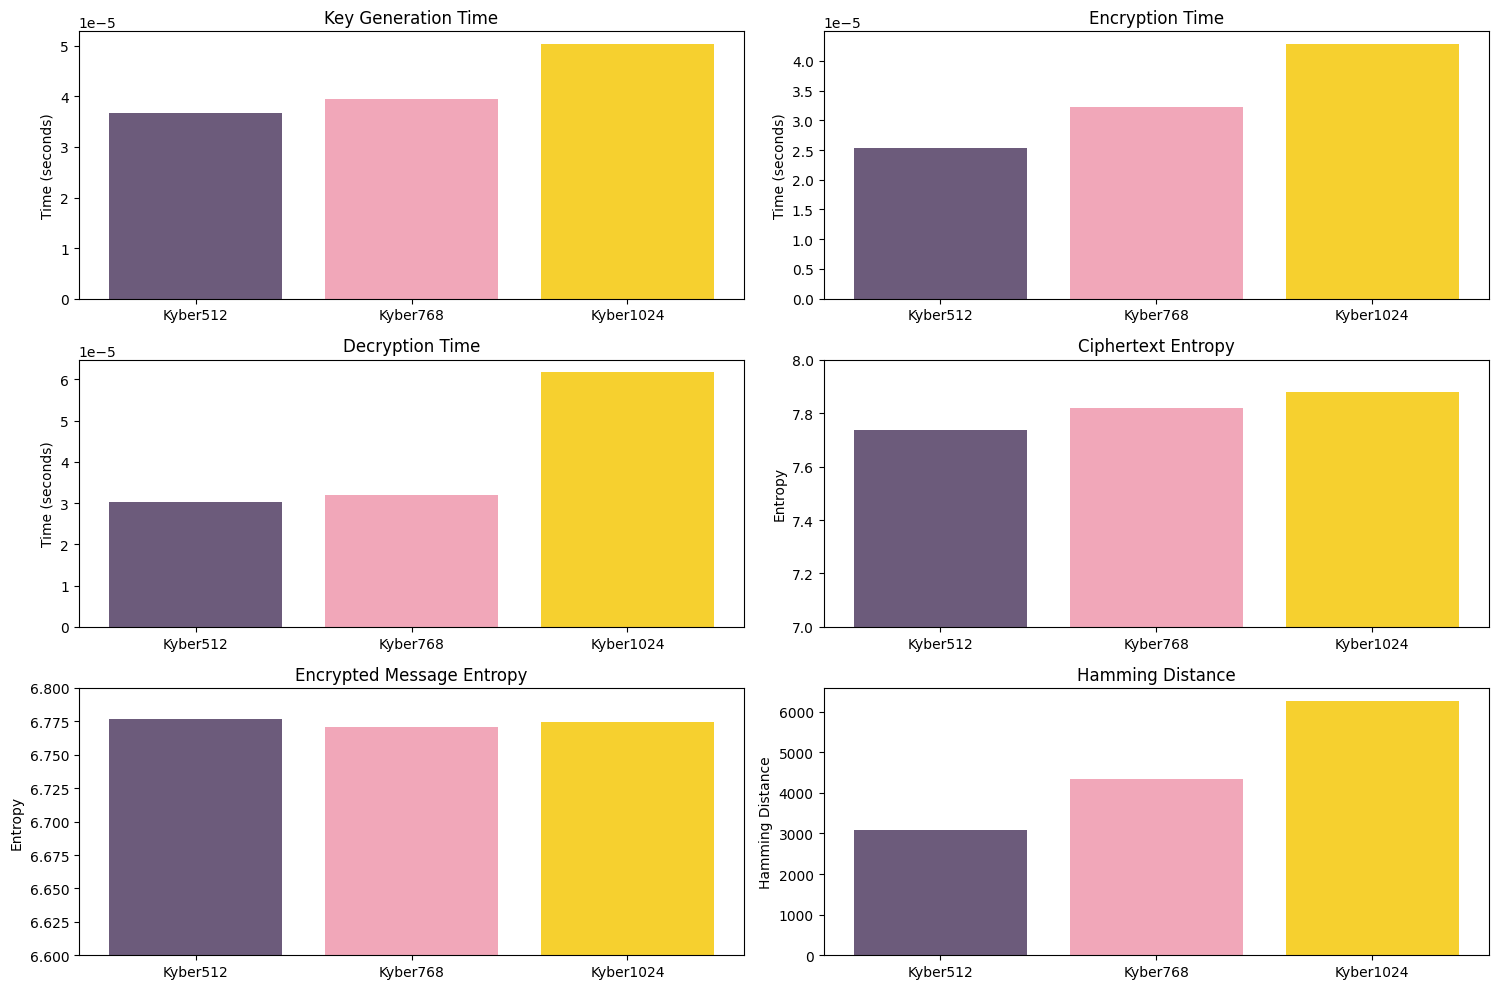

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' is already populated after running the algorithms
# Prepare data for plotting
metrics = ["keygen_time", "enc_time", "dec_time", "ciphertext_entropy", "entropy"]
algorithms = ["Kyber512", "Kyber768", "Kyber1024"]

# Extract the relevant results for each algorithm
keygen_times = [result["keygen_time"] for result in results]
enc_times = [result["enc_time"] for result in results]
dec_times = [result["dec_time"] for result in results]
ciphertext_entropies = [result["ciphertext_entropy"] for result in results]
encrypted_entropies = [result["entropy"] for result in results]
ham_dist = [result["hamming_distance"] for result in results]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Plot each metric
axes[0, 0].bar(algorithms, keygen_times, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[0, 0].set_title('Key Generation Time')
axes[0, 0].set_ylabel('Time (seconds)')

axes[0, 1].bar(algorithms, enc_times, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[0, 1].set_title('Encryption Time')
axes[0, 1].set_ylabel('Time (seconds)')

axes[1, 0].bar(algorithms, dec_times, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[1, 0].set_title('Decryption Time')
axes[1, 0].set_ylabel('Time (seconds)')

axes[1, 1].bar(algorithms, ciphertext_entropies, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[1, 1].set_title('Ciphertext Entropy')
axes[1, 1].set_ylabel('Entropy')
axes[1, 1].set_ylim(7, 8)  # Set y-axis scale for Ciphertext Entropy

axes[2, 0].bar(algorithms, encrypted_entropies, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[2, 0].set_title('Encrypted Message Entropy')
axes[2, 0].set_ylabel('Entropy')
axes[2, 0].set_ylim(6.6, 6.8)  # Set y-axis scale for Encrypted Message Entropy

axes[2, 1].bar(algorithms, ham_dist, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[2, 1].set_title('Hamming Distance')
axes[2, 1].set_ylabel('Hamming Distance')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

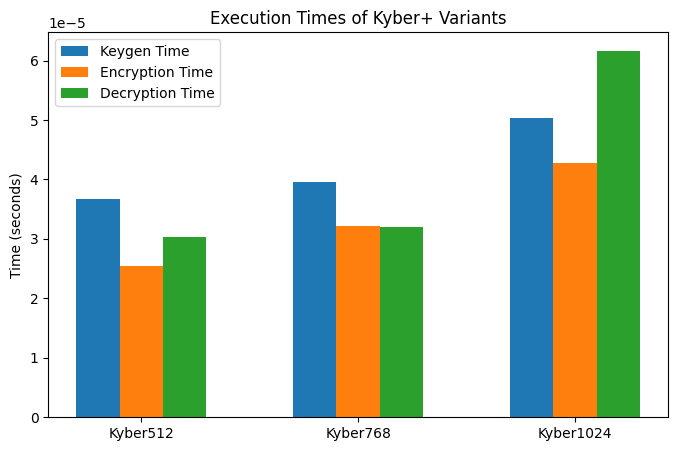

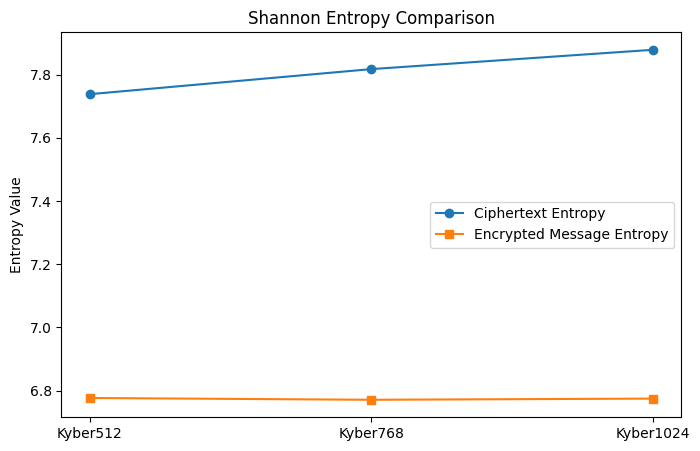

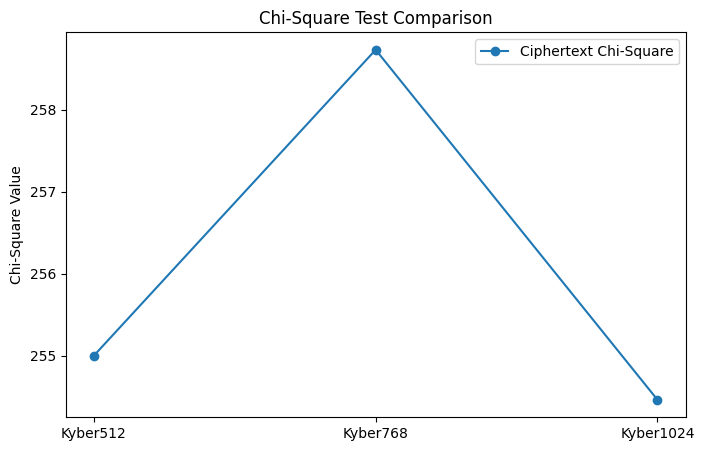

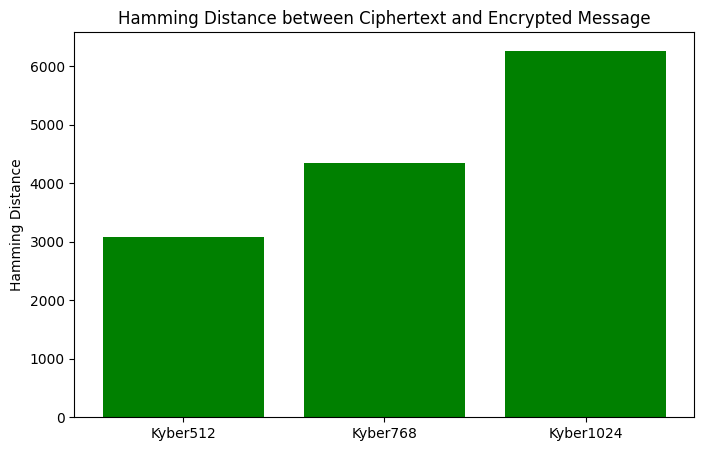

In [ ]:
# Extract data
algorithms = [r["algorithm"] for r in results]
keygen_times = [r["keygen_time"] for r in results]
enc_times = [r["enc_time"] for r in results]
dec_times = [r["dec_time"] for r in results]
ciphertext_entropy = [r["ciphertext_entropy"] for r in results]
encrypted_entropy = [r["entropy"] for r in results]
ciphertext_chi_square = [r["ciphertext_chi_square"] for r in results]
# encrypted_chi_square = [r["encrypted_chi_square"] for r in results]
hamming_distances = [r["hamming_distance"] for r in results]

# Plot Execution Times
plt.figure(figsize=(8, 5))
x = np.arange(len(algorithms))
width = 0.2
plt.bar(x - width, keygen_times, width, label="Keygen Time")
plt.bar(x, enc_times, width, label="Encryption Time")
plt.bar(x + width, dec_times, width, label="Decryption Time")
plt.xticks(x, algorithms)
plt.ylabel("Time (seconds)")
plt.title("Execution Times of Kyber+ Variants")
plt.legend()
plt.show()

# Plot Shannon Entropy & Chi-Square
plt.figure(figsize=(8, 5))
plt.plot(algorithms, ciphertext_entropy, marker='o', linestyle='-', label="Ciphertext Entropy")
plt.plot(algorithms, encrypted_entropy, marker='s', linestyle='-', label="Encrypted Message Entropy")
plt.ylabel("Entropy Value")
plt.title("Shannon Entropy Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(algorithms, ciphertext_chi_square, marker='o', linestyle='-', label="Ciphertext Chi-Square")
# plt.plot(algorithms, encrypted_chi_square, marker='s', linestyle='-', label="Encrypted Message Chi-Square")
plt.ylabel("Chi-Square Value")
plt.title("Chi-Square Test Comparison")
plt.legend()
plt.show()

# Plot Hamming Distance
plt.figure(figsize=(8, 5))
plt.bar(algorithms, hamming_distances, color='green')
plt.ylabel("Hamming Distance")
plt.title("Hamming Distance between Ciphertext and Encrypted Message")
plt.show()

600 sentences + chi quare +

In [ ]:
import time
import oqs
import threading
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import os
from collections import Counter
import math

def shannon_entropy(data):
    if not data:
        return 0
    frequency = Counter(data)  # Count occurrences of each byte
    total_length = len(data)
    entropy = -sum((count / total_length) * math.log2(count / total_length) for count in frequency.values())
    return entropy

# Chi-Square Test Calculation
def chi_square_test(data):
    expected_freq = len(data) / 256  # Expected uniform distribution
    observed_freq = Counter(data)  # Count occurrences of each byte

    chi_square_stat = sum(((observed_freq.get(byte, 0) - expected_freq) ** 2) / expected_freq for byte in range(256))
    return chi_square_stat

# Hamming Distance Calculation
def hamming_distance(data1, data2):
    """Compute Hamming Distance between two byte sequences."""
    return sum(bin(b1 ^ b2).count('1') for b1, b2 in zip(data1, data2))

# Hybrid encryption: AES with Kyber for key exchange
def hybrid_encrypt(shared_secret, plaintext):
    aes_key = shared_secret[:16]  # Use the first 16 bytes for AES key
    iv = os.urandom(16)  # Random initialization vector
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))
    return iv + ciphertext

def hybrid_decrypt(shared_secret, ciphertext):
    aes_key = shared_secret[:16]
    iv = ciphertext[:16]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    plaintext = unpad(cipher.decrypt(ciphertext[16:]), AES.block_size)
    return plaintext

# Multithreaded key generation, encryption, and decryption
def process_kyber(algo, plaintext):
    results = {}
    keygen_time = 0
    enc_time = 0
    dec_time = 0
    ciphertext_entropy = 0
    encrypted_entropy = 0
    ciphertext_chi_square = 0
    hamming_dist = 0

    with oqs.KeyEncapsulation(algo) as kem:
        for sentence in plaintext:
            pt = sentence.encode('utf-8')
            # Key generation
            start_time = time.time()
            public_key = kem.generate_keypair()
            # private_key = kem.export_secret_key()
            keygen_time += time.time() - start_time

            # Encryption
            start_time = time.time()
            ciphertext, shared_secret = kem.encap_secret(public_key)
            enc_time += time.time() - start_time

            ciphertext2, shared_secret2 = kem.encap_secret(public_key)
            hamming_dist += hamming_distance(ciphertext, ciphertext2)

            ciphertext_entropy += shannon_entropy(ciphertext)
            ciphertext_chi_square += chi_square_test(ciphertext)

            # Decryption
            start_time = time.time()
            shared_secret_dec = kem.decap_secret(ciphertext)
            dec_time += time.time() - start_time

            # Hybrid encryption and decryption
            encrypted_message = hybrid_encrypt(shared_secret, pt)
            decrypted_message = hybrid_decrypt(shared_secret_dec, encrypted_message)
            encrypted_entropy += shannon_entropy(encrypted_message)

        n = len(plaintext)
        results = {
            "keygen_time": keygen_time / n,
            "enc_time": enc_time / n,
            "dec_time": dec_time / n,
            "encrypted_message": encrypted_message,
            "decrypted_message": decrypted_message,
            "ciphertext_entropy": ciphertext_entropy / n,
            "entropy": encrypted_entropy / n,
            "ciphertext_chi_square": ciphertext_chi_square / n,
            "hamming_distance": hamming_dist / n,
        }

    return results

# Example plaintext to encrypt
plaintext = sentence_list_large

# Define the algorithms
algorithms = ["Kyber512", "Kyber768", "Kyber1024"]

# Store results
results = []

# Sequential execution (No Multithreading)
for algo in algorithms:
    result = process_kyber(algo, plaintext)
    result["algorithm"] = algo
    results.append(result)

# Display the results
for result in results:
    print(f"Algorithm: {result['algorithm']}")
    print(f"Key Generation Time: {result['keygen_time']:.6f} seconds")
    print(f"Encryption Time: {result['enc_time']:.6f} seconds")
    print(f"Decryption Time: {result['dec_time']:.6f} seconds")

    print(f"Encrypted Message: {result['encrypted_message']}")
    print(f"Decrypted Message: {result['decrypted_message']}")

    print(f"Shanon Entropy on CipherText: {result['ciphertext_entropy']}")
    print(f"Shanon Entropy on Encrypted Message: {result['entropy']}")
    print(f"Chi Square on ciphertext: {result['ciphertext_chi_square']}")
    print(f"Hamming Distance: {result['hamming_distance']}")

    print("-" * 30)

Algorithm: Kyber512
Key Generation Time: 0.000043 seconds
Encryption Time: 0.000035 seconds
Decryption Time: 0.000049 seconds
Encrypted Message: b'v%)\xe2\x1e\xb6\xa0m\xd1\xdb;\xd2\xda\xe7\x97\xc4\xdb\xb4]\xa4\xc4&tS\xff\x15\x04^`\r\x8dg\x01X\x0e\xab\x0b\xea\xf7\xf0\xcb+A\xd7\xae\xe7\x1c\xaf\xd95\xfd\x18i\xf5\xd2\xed*Zt\xab\xc31\x12\x95@iu\xaf\x15\xfa\xa49\x03\x9d\x17o\xbf\xee\x1d>^<\rXOsk\xfc\xdd\x83\x90\xd2\xd4\xf7\x9f\x95!A\xb6\xcc!O#\x1c\xfbK\xb0By\xd7\x86+'
Decrypted Message: b'You just stood there with your red plastic tray like there was this awful spotlight on you'
Shanon Entropy on CipherText: 7.739545485062201
Shanon Entropy on Encrypted Message: 6.260608306180795
Chi Square on ciphertext: 253.2255555555554
Hamming Distance: 3069.655
------------------------------
Algorithm: Kyber768
Key Generation Time: 0.000061 seconds
Encryption Time: 0.000046 seconds
Decryption Time: 0.000052 seconds
Encrypted Message: b"\xbb\x18\xea\xde\\\xf8'2P\xc6\xf1\x9f\x91`x\xedR\x9e\x16\xbb\x02lX9\

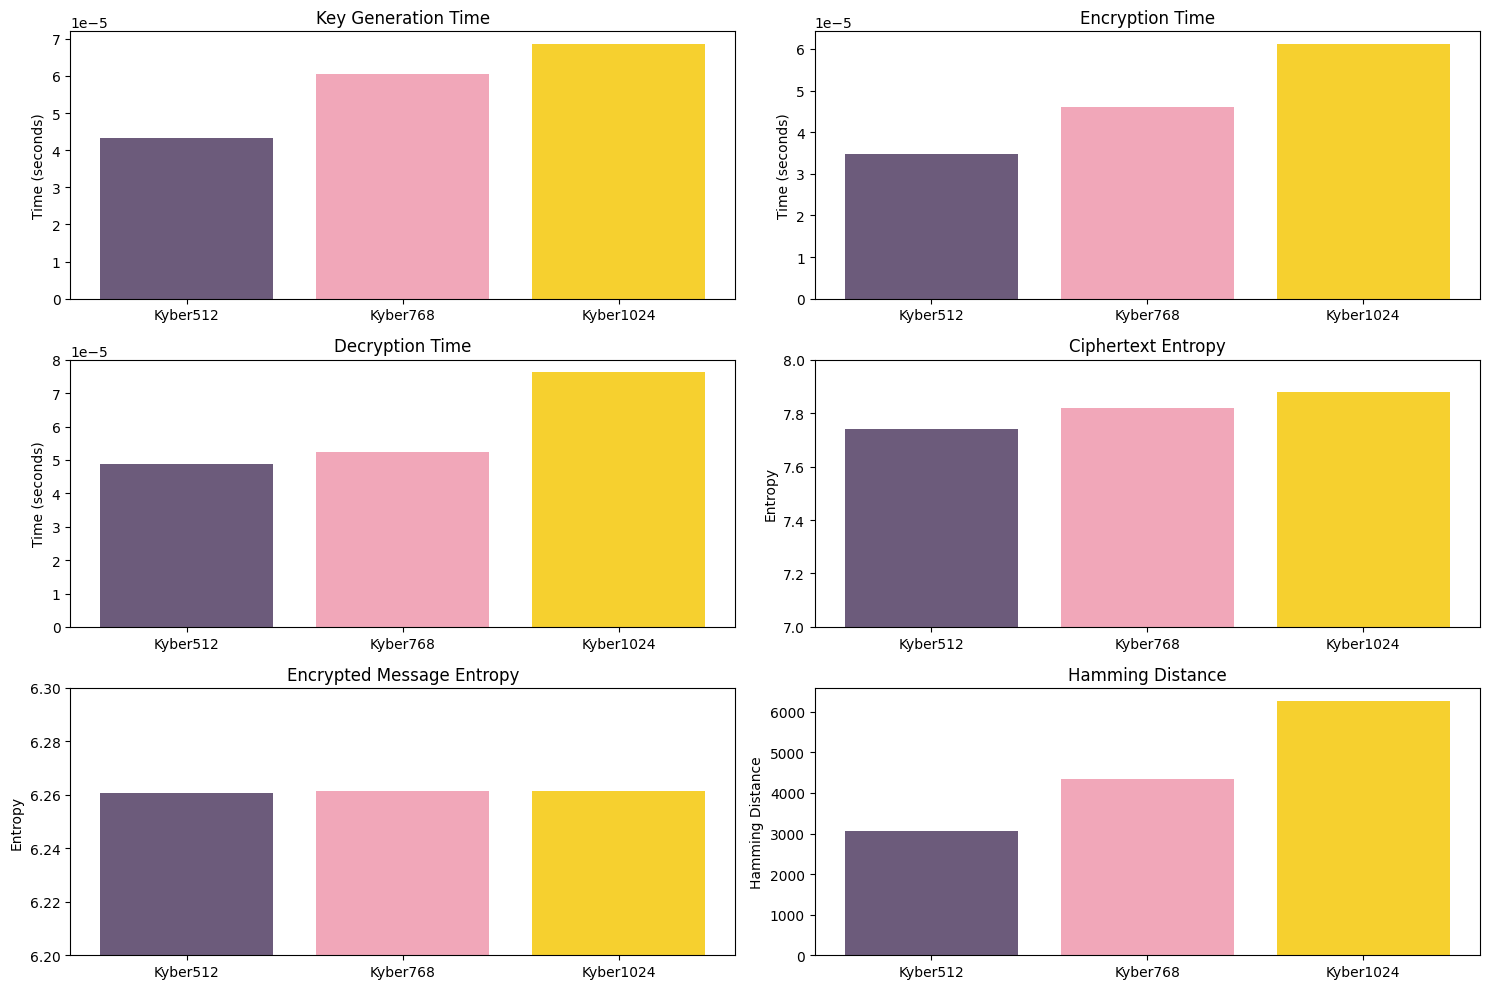

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' is already populated after running the algorithms
# Prepare data for plotting
metrics = ["keygen_time", "enc_time", "dec_time", "ciphertext_entropy", "entropy"]
algorithms = ["Kyber512", "Kyber768", "Kyber1024"]

# Extract the relevant results for each algorithm
keygen_times = [result["keygen_time"] for result in results]
enc_times = [result["enc_time"] for result in results]
dec_times = [result["dec_time"] for result in results]
ciphertext_entropies = [result["ciphertext_entropy"] for result in results]
encrypted_entropies = [result["entropy"] for result in results]
ham_dist = [result["hamming_distance"] for result in results]

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Plot each metric
axes[0, 0].bar(algorithms, keygen_times, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[0, 0].set_title('Key Generation Time')
axes[0, 0].set_ylabel('Time (seconds)')

axes[0, 1].bar(algorithms, enc_times, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[0, 1].set_title('Encryption Time')
axes[0, 1].set_ylabel('Time (seconds)')

axes[1, 0].bar(algorithms, dec_times, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[1, 0].set_title('Decryption Time')
axes[1, 0].set_ylabel('Time (seconds)')

axes[1, 1].bar(algorithms, ciphertext_entropies, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[1, 1].set_title('Ciphertext Entropy')
axes[1, 1].set_ylabel('Entropy')
axes[1, 1].set_ylim(7, 8)  # Set y-axis scale for Ciphertext Entropy

axes[2, 0].bar(algorithms, encrypted_entropies, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[2, 0].set_title('Encrypted Message Entropy')
axes[2, 0].set_ylabel('Entropy')
axes[2, 0].set_ylim(6.2, 6.3)  # Set y-axis scale for Encrypted Message Entropy

axes[2, 1].bar(algorithms, ham_dist, color=['#6C5B7B', '#F1A7B9', '#F6D02F'])
axes[2, 1].set_title('Hamming Distance')
axes[2, 1].set_ylabel('Hamming Distance')

# Hide the empty subplot
# axes[2, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

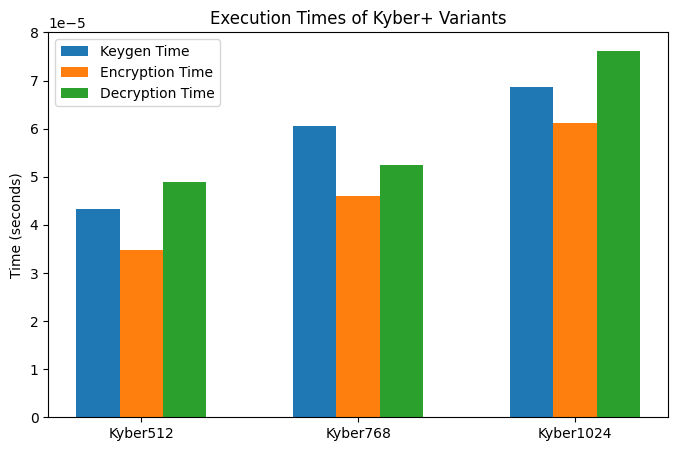

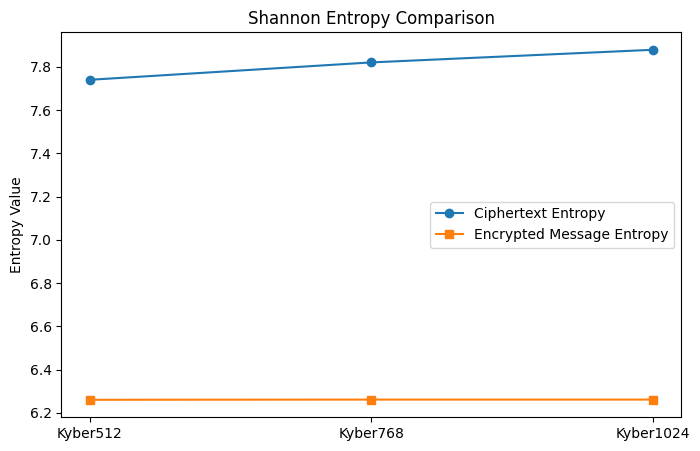

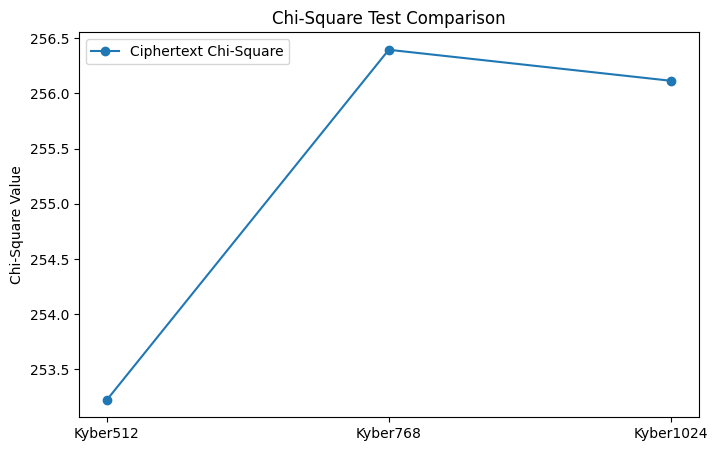

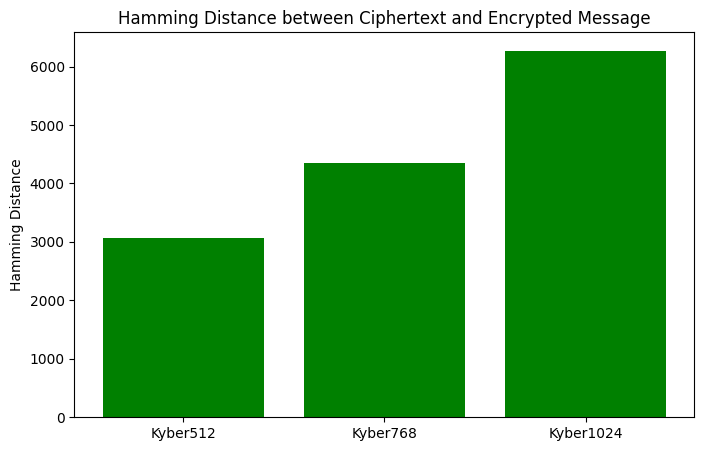

In [ ]:
# Extract data
algorithms = [r["algorithm"] for r in results]
keygen_times = [r["keygen_time"] for r in results]
enc_times = [r["enc_time"] for r in results]
dec_times = [r["dec_time"] for r in results]
ciphertext_entropy = [r["ciphertext_entropy"] for r in results]
encrypted_entropy = [r["entropy"] for r in results]
ciphertext_chi_square = [r["ciphertext_chi_square"] for r in results]
# encrypted_chi_square = [r["encrypted_chi_square"] for r in results]
hamming_distances = [r["hamming_distance"] for r in results]

# Plot Execution Times
plt.figure(figsize=(8, 5))
x = np.arange(len(algorithms))
width = 0.2
plt.bar(x - width, keygen_times, width, label="Keygen Time")
plt.bar(x, enc_times, width, label="Encryption Time")
plt.bar(x + width, dec_times, width, label="Decryption Time")
plt.xticks(x, algorithms)
plt.ylabel("Time (seconds)")
plt.title("Execution Times of Kyber+ Variants")
plt.legend()
plt.show()

# Plot Shannon Entropy & Chi-Square
plt.figure(figsize=(8, 5))
plt.plot(algorithms, ciphertext_entropy, marker='o', linestyle='-', label="Ciphertext Entropy")
plt.plot(algorithms, encrypted_entropy, marker='s', linestyle='-', label="Encrypted Message Entropy")
plt.ylabel("Entropy Value")
plt.title("Shannon Entropy Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(algorithms, ciphertext_chi_square, marker='o', linestyle='-', label="Ciphertext Chi-Square")
# plt.plot(algorithms, encrypted_chi_square, marker='s', linestyle='-', label="Encrypted Message Chi-Square")
plt.ylabel("Chi-Square Value")
plt.title("Chi-Square Test Comparison")
plt.legend()
plt.show()

# Plot Hamming Distance
plt.figure(figsize=(8, 5))
plt.bar(algorithms, hamming_distances, color='green')
plt.ylabel("Hamming Distance")
plt.title("Hamming Distance between Ciphertext and Encrypted Message")
plt.show()